# Load modules

In [1]:
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pybedtools import BedTool
import pyfaidx
import sys

2024-05-01 17:54:17.337537: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 17:54:17.379922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 17:54:17.379971: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 17:54:17.380004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 17:54:17.388815: I tensorflow/core/platform/cpu_feature_g

# Load models and data

In [15]:
sys.path.append('../deeppeak/training/')
from utils.metrics import *
from utils.loss import *
# Specify your custom objects in a dictionary
custom_objects = {'CustomLossMSELogV2_': CustomLossMSELogV2_, 'get_lr_metric': get_lr_metric, 'LogMSEPerClassCallback': LogMSEPerClassCallback, 'PearsonCorrelation': PearsonCorrelation, 'ZeroPenaltyMetric':ZeroPenaltyMetric, 'SpearmanCorrelationPerClass':SpearmanCorrelationPerClass, 'PearsonCorrelationLog':PearsonCorrelationLog, 'ConcordanceCorrelationCoefficient': ConcordanceCorrelationCoefficient}  # Replace 'CustomLayer' with your actual layer/class name

In [2]:
from tensorflow.keras.models import load_model

model_dict={}

model_path = "/data/projects/c04/cbd-saerts/nkemp/mouse/biccn/deeppeak/runs/test/checkpoints/01.h5"
model = load_model(model_path, compile=False)#, custom_objects=custom_objects)
model_dict['test']=model

Instructions for updating:
Colocations handled automatically by placer.


2024-04-28 13:17:16.633492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
2024-04-28 13:17:16.660591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-04-28 13:17:17.344560: W tensorflow/c/c_api.cc:305] Operation '{name:'bpnet_8bn/moving_mean/Assign' id:1125 op device:{requested: '', assigned: ''} def:{{{node bpnet_8bn/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bpnet_8bn/moving_mean, bpnet_8bn/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [2]:
from tensorflow.keras.models import load_model

model_dict={}

#model_path = '/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/checkpoints/mouse/basenji/checkpoints/14.keras'
#model = load_model(model_path, compile=False)
#model_dict['basenji']=model


model_path = "/data/projects/c04/cbd-saerts/nkemp/mouse/biccn/deeppeak/runs/cbpnet_big_loglossdynamic/checkpoints/35.keras"
model = load_model(model_path, compile=False)#, custom_objects=custom_objects)
model_dict['bigboy']=model

#model_path = "/data/projects/c04/cbd-saerts/nkemp/mouse/biccn/deeppeak/runs/bigboy_TL/checkpoints/08.keras"
#model = load_model(model_path, compile=False)
#model_dict['bigboy_TL']=model

model_path = "/data/projects/c04/cbd-saerts/nkemp/mouse/biccn/deeppeak/runs/bigboy_TL_smallerLR/checkpoints/14.keras"
model = load_model(model_path, compile=False)
model_dict['bigboy_TL_1e-5']=model

#model_path = "/data/projects/c04/cbd-saerts/nkemp/mouse/biccn/deeppeak/runs/cbpnet_revcomall_peaknorm/checkpoints/31.keras"
#model = load_model(model_path, compile=False)#, custom_objects=custom_objects)
#model_dict['rc']=model

model_path = "/data/projects/c04/cbd-saerts/nkemp/mouse/biccn/deeppeak/runs/cbpnet_revcomall_peaknorm_TL/checkpoints/16.keras"
model = load_model(model_path, compile=False)#, custom_objects=custom_objects)
model_dict['rc_TL']=model

model_path = "/data/projects/c04/cbd-saerts/nkemp/mouse/biccn/deeppeak/runs/softplus_TL/checkpoints/12.keras"
model = load_model(model_path, compile=False)
model_dict['softplus_TL']=model


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100 80GB PCIe, compute capability 8.0


2024-05-01 18:05:19.396315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0


## Load the training, validation and test data

In [3]:
split_dir = '/data/projects/c04/cbd-saerts/nkemp/mouse/biccn/deeppeak/runs/softplus_TL'#bigboy_TL'

ids = np.load(split_dir+'/region_split_ids.npz')
test_ids = ids['test']
train_ids = ids['train']
valid_ids = ids['val']
targets = np.load(split_dir+'/targets.npz')
test_targets = targets['test']
train_targets = targets['train']
valid_targets = targets['val']

In [6]:
all_targets = np.concatenate((train_targets, valid_targets, test_targets), axis=0)
all_ids = np.concatenate((train_ids, valid_ids, test_ids), axis=0)

# Create an empty array of the same shape as original_array to hold the sorted elements
sorted_targets = np.empty_like(all_targets)
# Place elements at their new positions
sorted_targets[all_ids] = all_targets
#all_ids.shape

## Load the consensuspeaks

In [7]:
# Specify the path to your BED file
bed_file_path = split_dir+'/regions.bed'

# Load the BED file into a DataFrame
bed_df = pd.read_csv(bed_file_path, sep='\t', header=None, names=['chrom', 'start', 'end', 'name'])
genome = '/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/data/raw/genome.fa'
bed_df

,chrom,start,end,name
0,chr1,3093998,3096112,+
1,chr1,3094663,3096777,+
2,chr1,3112727,3114841,+
3,chr1,3133779,3135893,+
4,chr1,3164901,3167015,+
...,...,...,...,...
89180,chrX,169812832,169814946,+
89181,chrX,169824148,169826262,+
89182,chrX,169837427,169839541,+
89183,chrX,169838199,169840313,+


In [9]:
import sys
sys.path.append('../')
from enhancerai.evaluate.utils.one_hot_encoding import region_to_one_hot_encoding, regions_to_hot_encoding, get_hot_encoding_table

genomic_pyfasta = pyfaidx.Fasta(genome, sequence_always_upper=True)
hot_encoding_table = get_hot_encoding_table()

# Model predictions

In [10]:
# Define classes
classes = ['Astro','Endo','L2_3IT','L5ET','L5IT','L5_6NP','L6CT','L6IT','L6b','Lamp5','Micro_PVM','OPC','Oligo','Pvalb','Sncg','Sst','Sst-Chodl','VLMC','Vip']

## Predicting on a test set region

chr18:84371728-84373842


2024-05-01 18:05:54.289262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


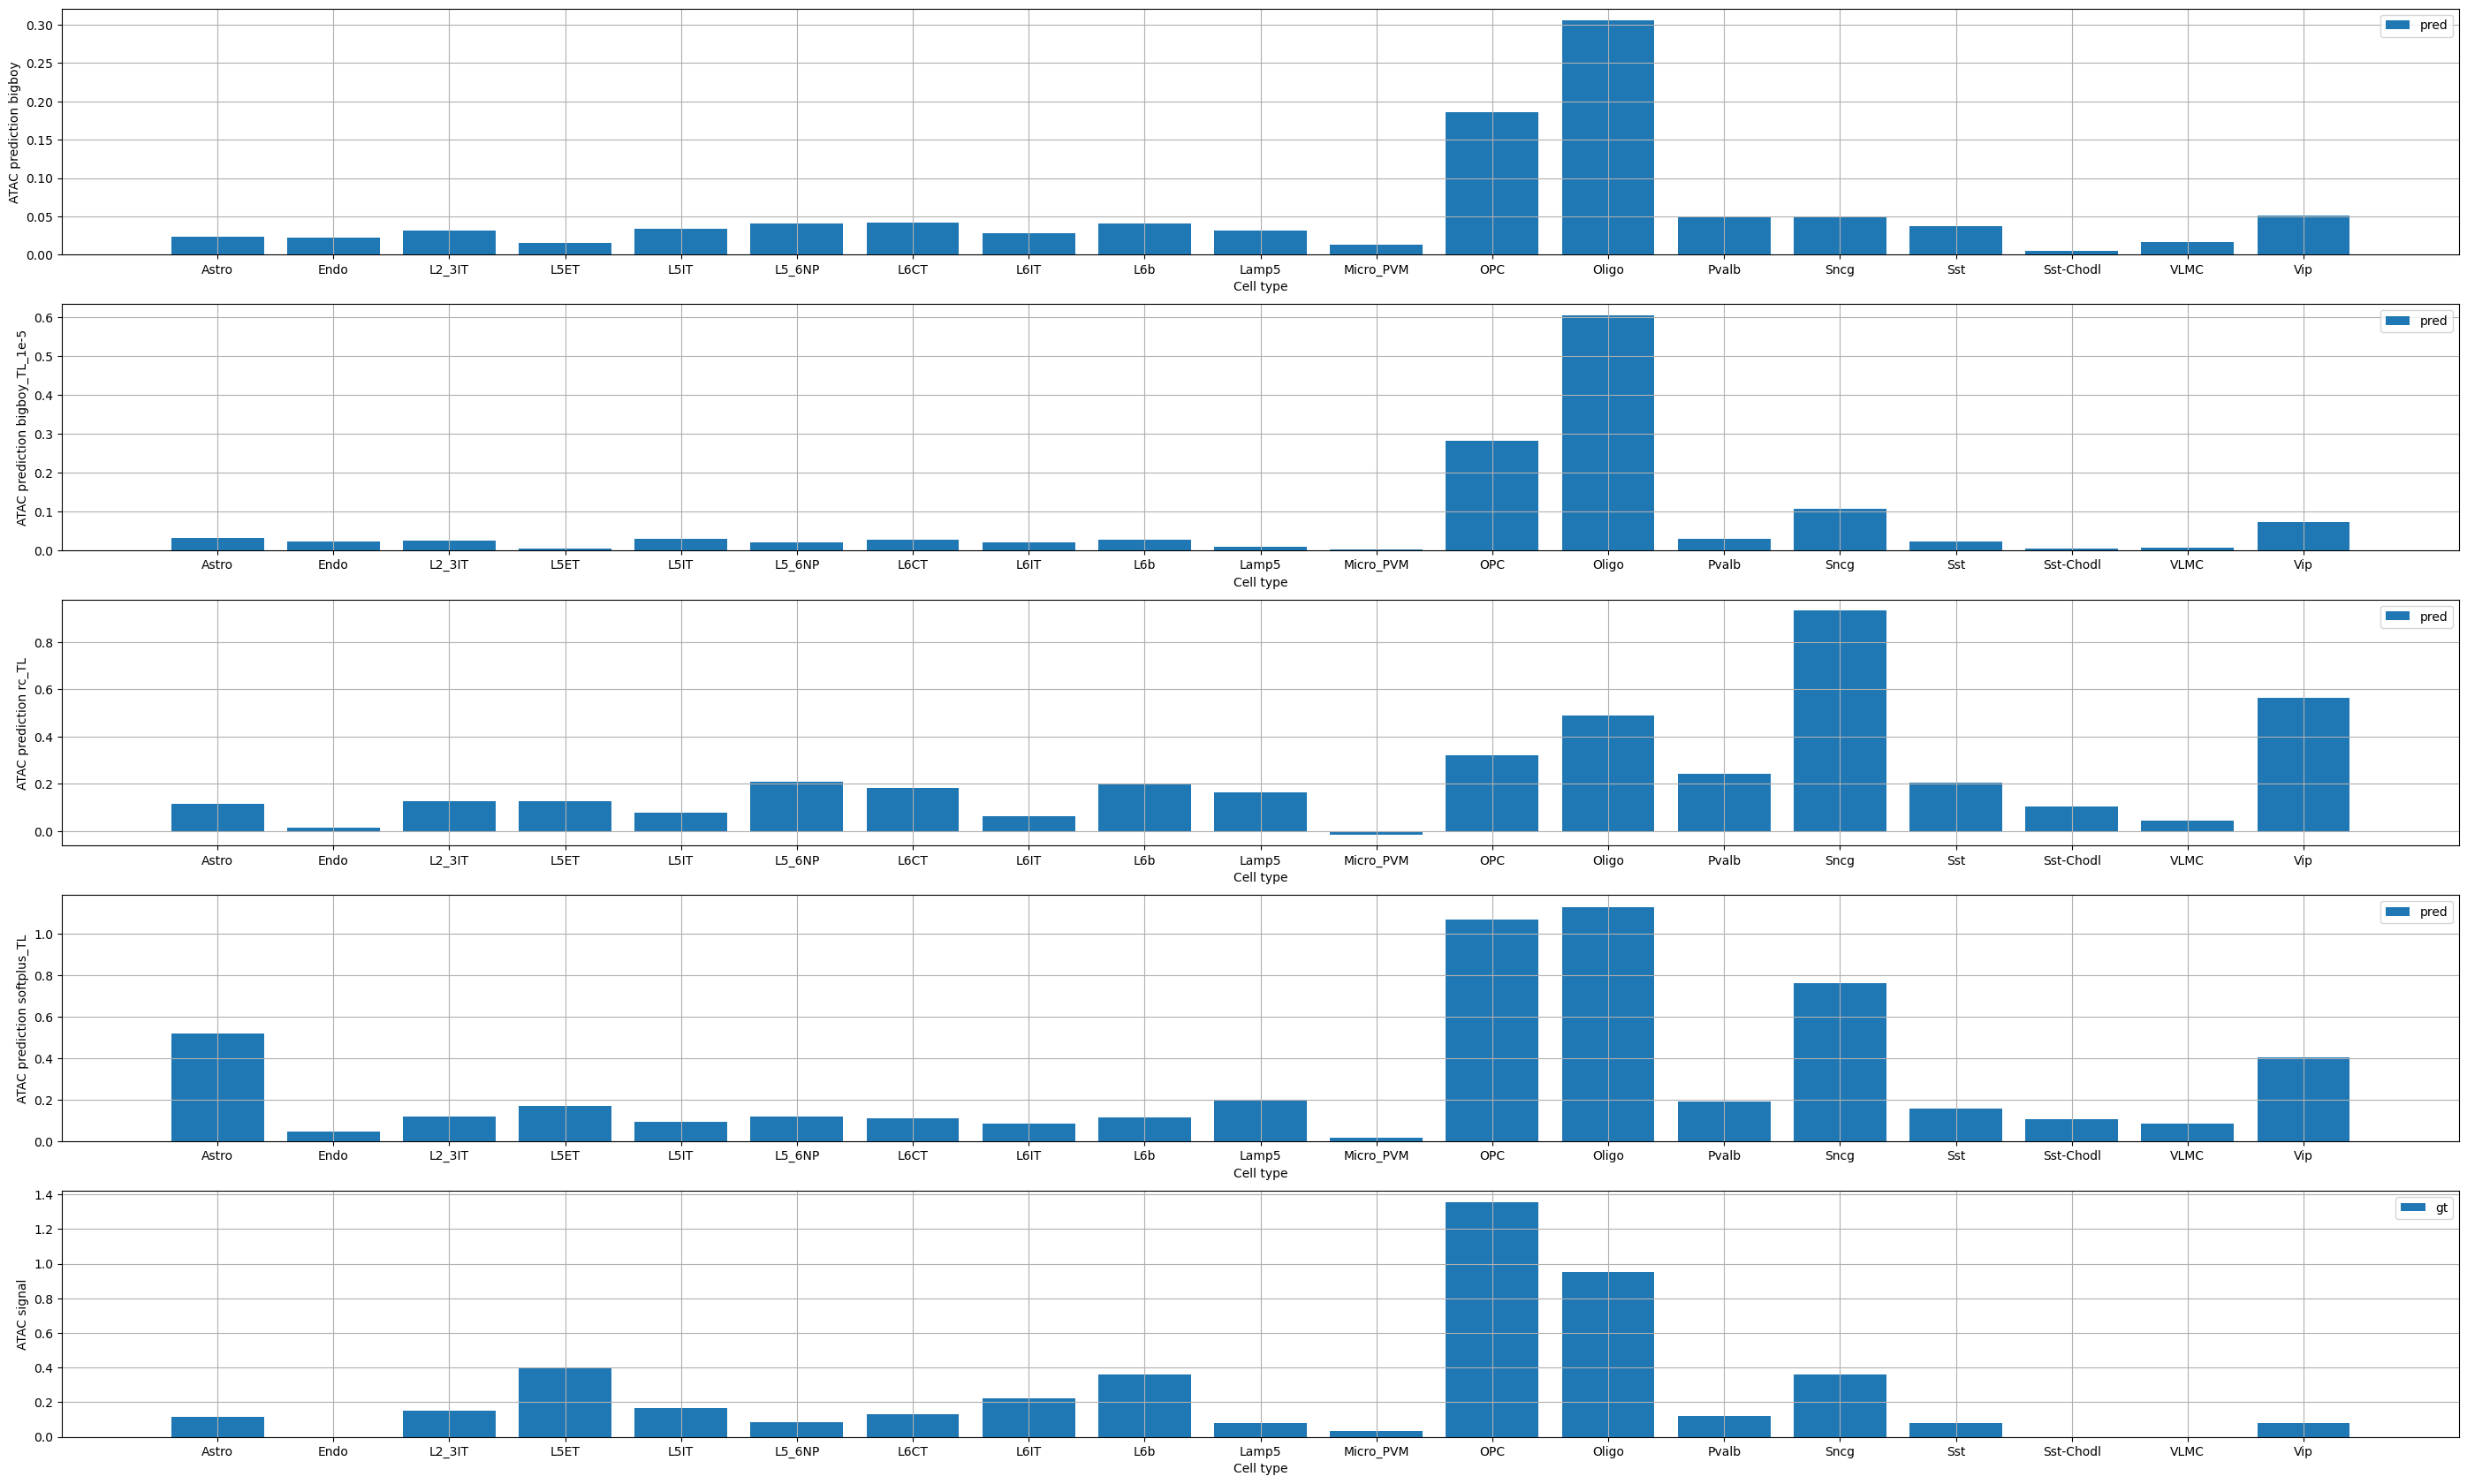

In [11]:
idx= 3155 # test set index
region = bed_df.iloc[test_ids[idx]]
seq_onehot = region_to_one_hot_encoding(region['chrom'],region['start'], region['end'], genomic_pyfasta, hot_encoding_table)

print(bed_df.iloc[test_ids[idx]]['chrom']+':'+str(bed_df.iloc[test_ids[idx]]['start'])+'-'+str(bed_df.iloc[test_ids[idx]]['end']))

ntrack = len(model_dict.keys())
fig = plt.figure(figsize=(35,5*ntrack+1))
for i, model in enumerate(model_dict):
    plt.subplot(ntrack+1,1,i+1)
    plt.bar(classes, model_dict[model].predict(seq_onehot, verbose=0)[0], label='pred')
    #plt.bar(classes_, model_dict[model].predict(seq_onehot)[0], label='pred')
    plt.legend()
    plt.xlabel('Cell type')
    plt.xticks(np.arange(0,len(classes)))
    plt.xticks(rotation=0)

    plt.ylabel('ATAC prediction '+model)
    plt.grid('on')

plt.subplot(ntrack+1,1,ntrack+1)
plt.bar(classes,test_targets[idx:idx+1][0], label='gt')
plt.xticks(rotation=0)
plt.legend()
plt.xlabel('Cell type')
plt.ylabel('ATAC signal')
plt.grid('on')
plt.show()

## Predictions on entire test set

In [70]:
# One hot encode all peaks
seqs = regions_to_hot_encoding(regions_bed_filename=bed_file_path,genomic_pyfasta=genomic_pyfasta, hot_encoding_table=hot_encoding_table)

One hot encoding sequences...


100%|██████████| 89185/89185 [00:04<00:00, 18049.82it/s]


In [71]:
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics.pairwise import cosine_similarity

# Initialize dictionaries to store the correlation scores and predicted values
correlation_scores_spearman_incl_zeros = {}
correlation_scores_spearman_excl_zeros = {}
correlation_scores_pearson = {}
correlation_scores_pearson_log = {}
predicted_values = {}  # Store the predicted values for each model
cosine_similarity_scores = {}  # Store the cosine similarity scores for each model

for model_name, model in model_dict.items():
    if model_name in model_dict.keys():
        scores_spearman_incl_zeros = []
        scores_spearman_excl_zeros = []
        scores_pearson = []
        scores_pearson_log = []

        predictions = model.predict(seqs[test_ids])  # Calculate the predictions once
        predicted_values[model_name] = predictions

        for i, bw in enumerate(classes):
            true_values = test_targets[:, i]

            # Spearman (including zeros)
            spearman_score_incl_zeros, _ = spearmanr(predictions[:, i], true_values)
            scores_spearman_incl_zeros.append(spearman_score_incl_zeros)

            # Spearman (excluding zeros)
            non_zero_indices = np.nonzero(true_values)[0]  # Adjust for correct indexing
            if len(non_zero_indices) > 0:
                spearman_score_excl_zeros, _ = spearmanr(predictions[non_zero_indices, i], true_values[non_zero_indices])
                scores_spearman_excl_zeros.append(spearman_score_excl_zeros)
            else:
                scores_spearman_excl_zeros.append(np.nan)  # Append NaN if there are no non-zero indices

            # Pearson (including zeros)
            pearson_score, _ = pearsonr(predictions[:, i], true_values)
            pearson_score_log, _ = pearsonr(np.log(predictions[:, i]+1), np.log(true_values+1))
            scores_pearson.append(pearson_score)
            scores_pearson_log.append(pearson_score_log)

        correlation_scores_spearman_incl_zeros[model_name] = scores_spearman_incl_zeros
        correlation_scores_spearman_excl_zeros[model_name] = scores_spearman_excl_zeros
        correlation_scores_pearson[model_name] = scores_pearson
        correlation_scores_pearson_log[model_name] = scores_pearson_log

        # Cosine Similarity - calculate for the overall predictions vs. true values
        cosine_sims = [cosine_similarity(predictions[i:i+1], test_targets[i:i+1])[0, 0] for i in range(predictions.shape[0])]
        
        # Calculate the average cosine similarity per sample
        average_cosine_sim = np.mean(cosine_sims)
        cosine_similarity_scores[model_name] = average_cosine_sim

250/250 [==============================] - 5s 18ms/step


In [72]:
# Initialize a dictionary to store the data
data = {
    'Model': [],
    'Spearman Correlation (incl zeros)': [],
    'Spearman Correlation (excl zeros)': [],
    'Pearson Correlation': [],
    'Pearson Correlation (Log)': [],
    'Cosine Similarity': []
}

# Populate the dictionary with the calculated values
for model_name in model_dict.keys():
    data['Model'].append(model_name)
    data['Spearman Correlation (incl zeros)'].append(np.mean(correlation_scores_spearman_incl_zeros[model_name]))
    data['Spearman Correlation (excl zeros)'].append(np.mean(correlation_scores_spearman_excl_zeros[model_name]))
    data['Pearson Correlation'].append(np.mean(correlation_scores_pearson[model_name]))
    data['Pearson Correlation (Log)'].append(np.mean(correlation_scores_pearson_log[model_name]))
    data['Cosine Similarity'].append(cosine_similarity_scores[model_name])

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(data)

# Print the DataFrame
results_df

,Model,Spearman Correlation (incl zeros),Spearman Correlation (excl zeros),Pearson Correlation,Pearson Correlation (Log),Cosine Similarity
0,bigboy,0.546837,0.539514,0.645207,0.647932,0.820072
1,bigboy_TL_1e-5,0.547894,0.544051,0.668651,0.670162,0.811373
2,rc_TL,0.449576,0.447553,0.588152,0.586630,0.803587
3,softplus_TL,0.459984,0.461458,0.608517,0.616647,0.821856


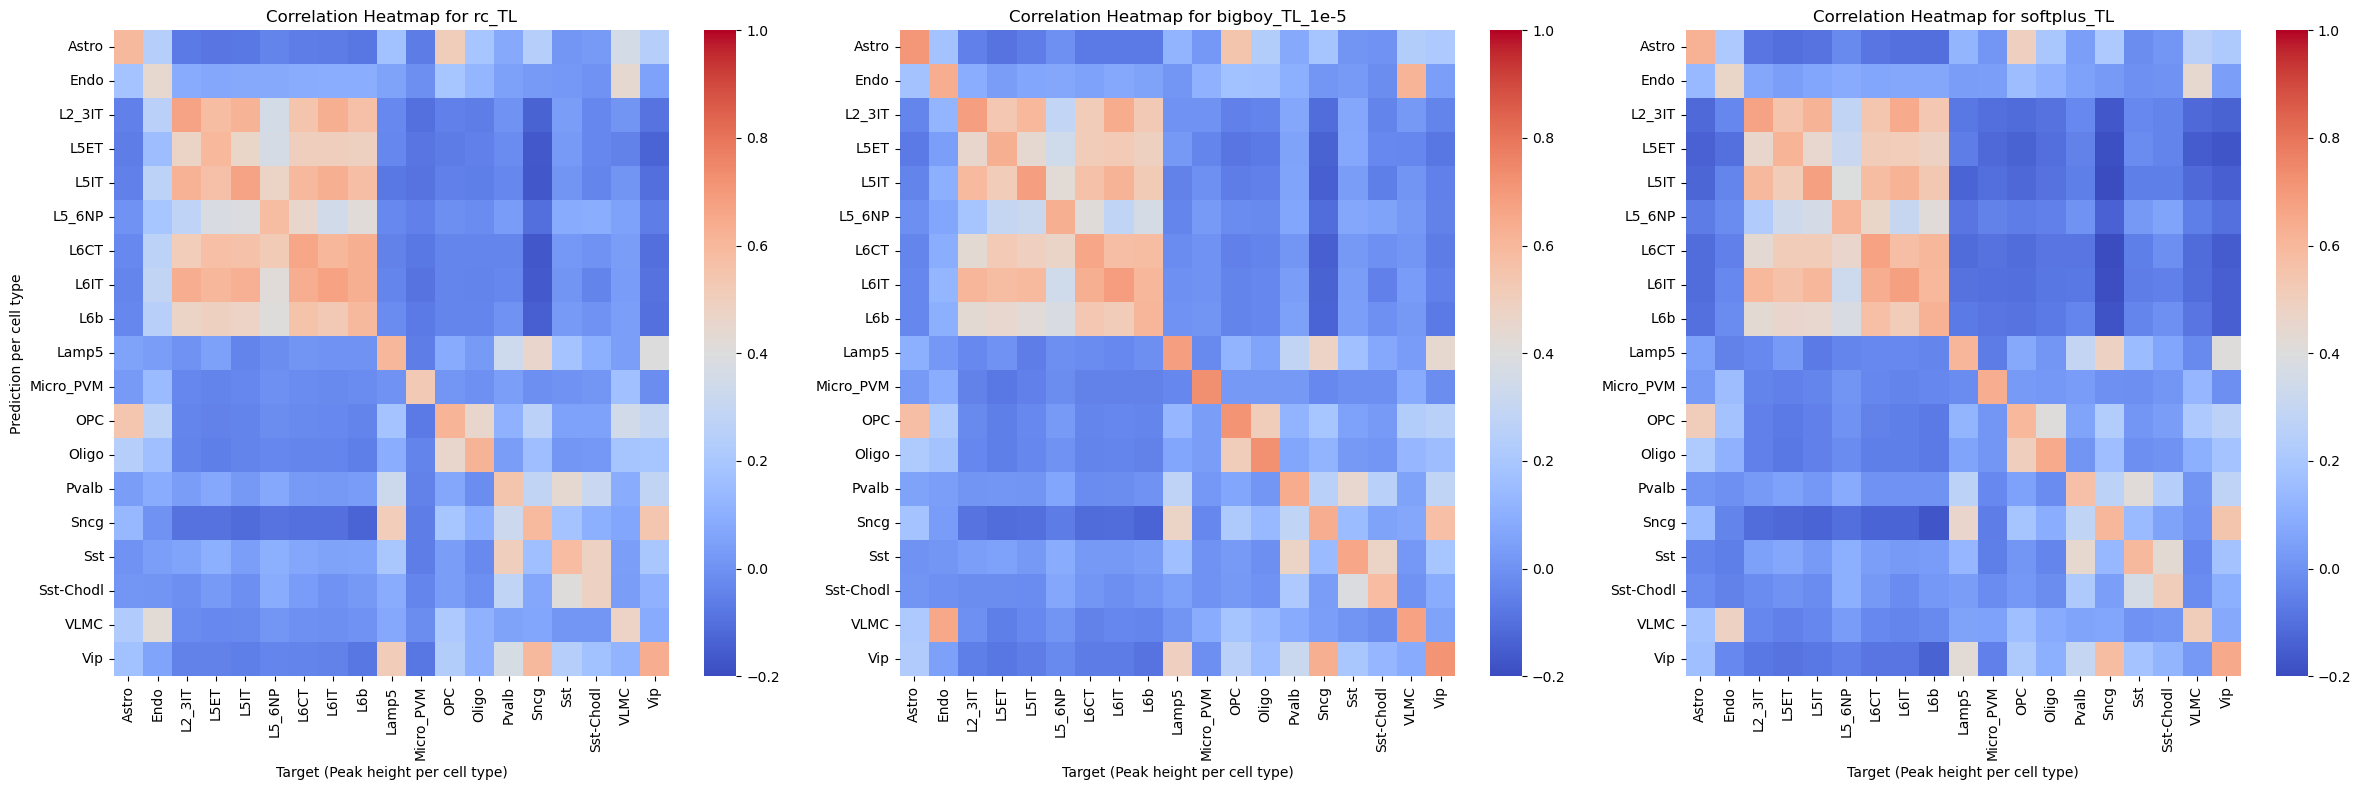

In [73]:
import seaborn as sns

def plot_correlation_heatmaps(x, predicted_values, classes, models_to_plot, log_transform=False):
    # Handle log transformation if requested
    if log_transform:
        x = np.log(x+1)
        for key in predicted_values:
            if key in models_to_plot:  # Only transform specified models
                predicted_values[key] = np.log(predicted_values[key]+1)

    n_models = len(models_to_plot)
    n_features = x.shape[1]

    # Setting up the subplot grid
    fig, axes = plt.subplots(1, n_models, figsize=(8 * n_models, 8), sharey=False)
    if n_models == 1:  # Adjust if only one model to plot for consistent indexing
        axes = [axes]

    # Iterate through each specified model's predictions
    for ax, model_name in zip(axes, models_to_plot):
        if model_name in predicted_values:
            y = predicted_values[model_name]
            # Initialize a matrix to store the correlations
            correlation_matrix = np.zeros((n_features, n_features))

            # Calculate the correlation for each pair of prediction-target
            for i in range(n_features):
                for j in range(n_features):
                    correlation_matrix[i, j] = np.corrcoef(x[:, i], y[:, j])[0, 1]

            # Plot the heatmap on a designated subplot
            sns.heatmap(correlation_matrix, cmap='coolwarm',
                        xticklabels=classes, yticklabels=classes, vmin=-0.2, vmax=1,
                        ax=ax)
            ax.set_title(f'Correlation Heatmap for {model_name}')
            ax.set_xlabel('Target (Peak height per cell type)')
            if ax is axes[0]:  # Only set ylabel for the first subplot to avoid repetition
                ax.set_ylabel('Prediction per cell type')

    plt.tight_layout()
    plt.show()

plot_correlation_heatmaps(test_targets, predicted_values.copy(), classes, ['rc_TL', 'bigboy_TL_1e-5','softplus_TL'], log_transform=False)

#### Always interesting to also look at the autocorrelation of the peaks

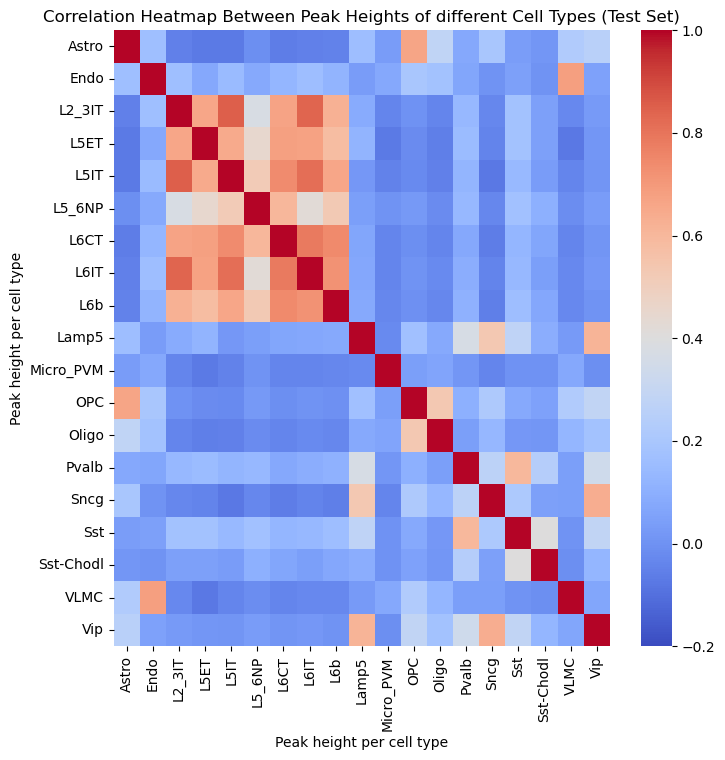

In [19]:
x = np.log(test_targets+1)
y = np.log(test_targets+1)

# Number of features (assuming predictions and ground_truth have the same number of features)
n_features = x.shape[1]

# Initialize a matrix to store the correlations
correlation_matrix = np.zeros((n_features, n_features))

# Calculate the correlation for each pair of prediction-target
for i in range(n_features):
    for j in range(n_features):
        correlation_matrix[i, j] = np.corrcoef(x[:, i], y[:, j])[0, 1]

# Create the heatmap
plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', xticklabels=classes, yticklabels=classes, vmin=-0.2, vmax=1)

plt.xlabel('Peak height per cell type')
plt.ylabel('Peak height per cell type')
plt.title('Correlation Heatmap Between Peak Heights of different Cell Types (Test Set)')
plt.show()

### Scatter plot for predictions on a given cell type

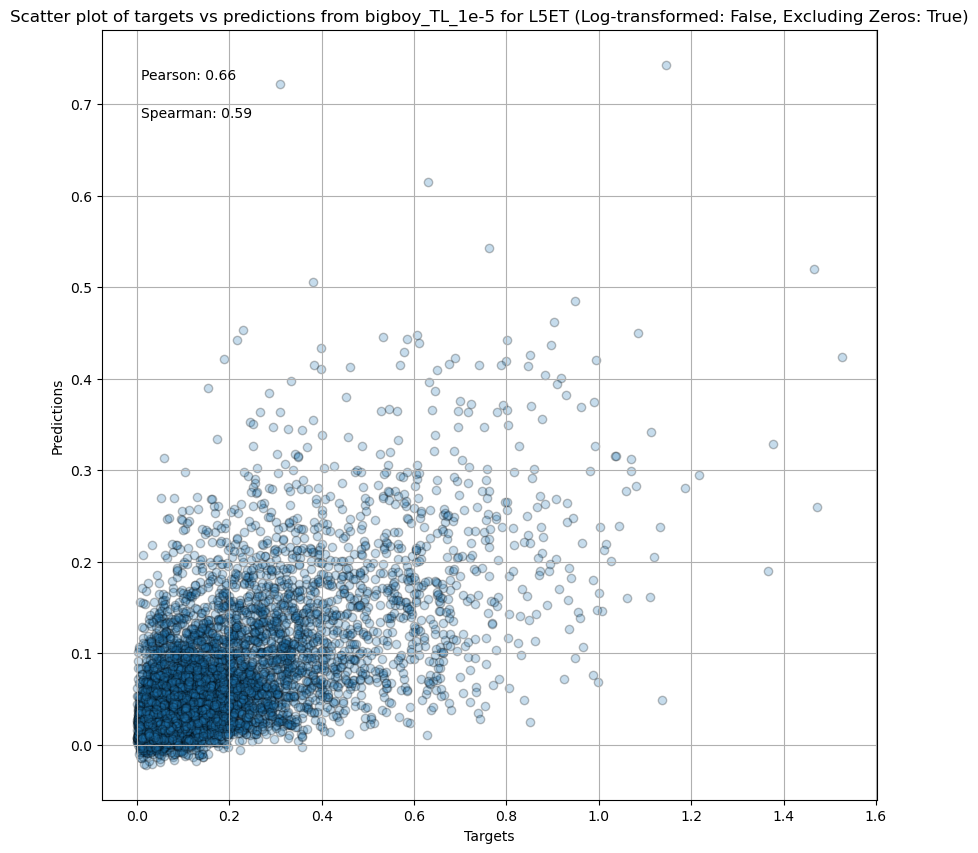

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr, spearmanr

def plot_density_scatter(test_targets, predictions, model_name, class_name, classes, exclude_zeros=True, density_indication=False, log_transform=False):
    # Find the index of the class name in the classes array
    column_index = np.where(np.array(classes) == class_name)[0][0]
    
    # Flatten the array and select the specified column
    x = test_targets[:, column_index].flatten()
    y = predictions[model_name][:, column_index].flatten()
    
    # Optionally exclude zero values
    if exclude_zeros:
        mask = (x != 0)
        x = x[mask]
        y = y[mask]

    if log_transform:
        x = np.log(x+1)
        y = np.log(y+1)
    
    # Calculate Pearson and Spearman correlations
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)

    # Plot the density scatter plot
    fig, ax = plt.subplots(figsize=(10,10))
    plt.grid(True)
    if density_indication:
        # Calculate the point density
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        scatter = ax.scatter(x, y, c=z, s=50, edgecolor='k', alpha=0.25)
        plt.colorbar(scatter, ax=ax, label='Density')
    else:
        scatter = ax.scatter(x, y, edgecolor='k', alpha=0.25)

    # Annotate the plot with correlations
    plt.annotate(f'Pearson: {pearson_corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', verticalalignment='top')
    plt.annotate(f'Spearman: {spearman_corr:.2f}', xy=(0.05, 0.90), xycoords='axes fraction', verticalalignment='top')

    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.title(f'Scatter plot of targets vs predictions from {model_name} for {class_name} (Log-transformed: {log_transform}, Excluding Zeros: {exclude_zeros})')
    plt.show()

plot_density_scatter(test_targets, predicted_values, 'bigboy_TL_1e-5','L5ET', classes)

# Model interpretations

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import sys
#sys.path.append('../deeppeak/evaluate')
sys.path.append('../')
import pandas as pd 

from enhancerai.evaluate.utils.explain import Explainer, grad_times_input_to_df, plot_attribution_map
from enhancerai.evaluate.interpret import calculate_gradient_scores, visualize_scores, visualize_mutagenesis_effects

def plot_tracks(seq_onehot, location, model, subset, classes, method='expected_integrated_grad', zoom=500, savefig=''):
    scores = calculate_gradient_scores(
        model,
        seq_onehot,
        '',
        class_indices=subset,
        method=method,
        verbose=False
    )
    if method=='mutagenesis':
        visualize_mutagenesis_effects(
            scores,
            seq_onehot,
            savefig,
            [location],
            class_indices=subset,
            zoom_n_bases=zoom,
            class_names=classes,
            verbose=False
        )
    else:
        visualize_scores(
            scores,
            seq_onehot,
            savefig,
            [location],
            class_indices=subset,
            zoom_n_bases=zoom,
            class_names=classes,
            verbose=False
        )

In [10]:
!pwd

/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/notebooks


## Explanation for a random test set region

1/1 [==============================] - 0s 25ms/step


Calculating scores per class for all regions: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


(1, 3, 2114, 4)


Plotting scores per seq:   0%|          | 0/1 [00:00<?, ?it/s]

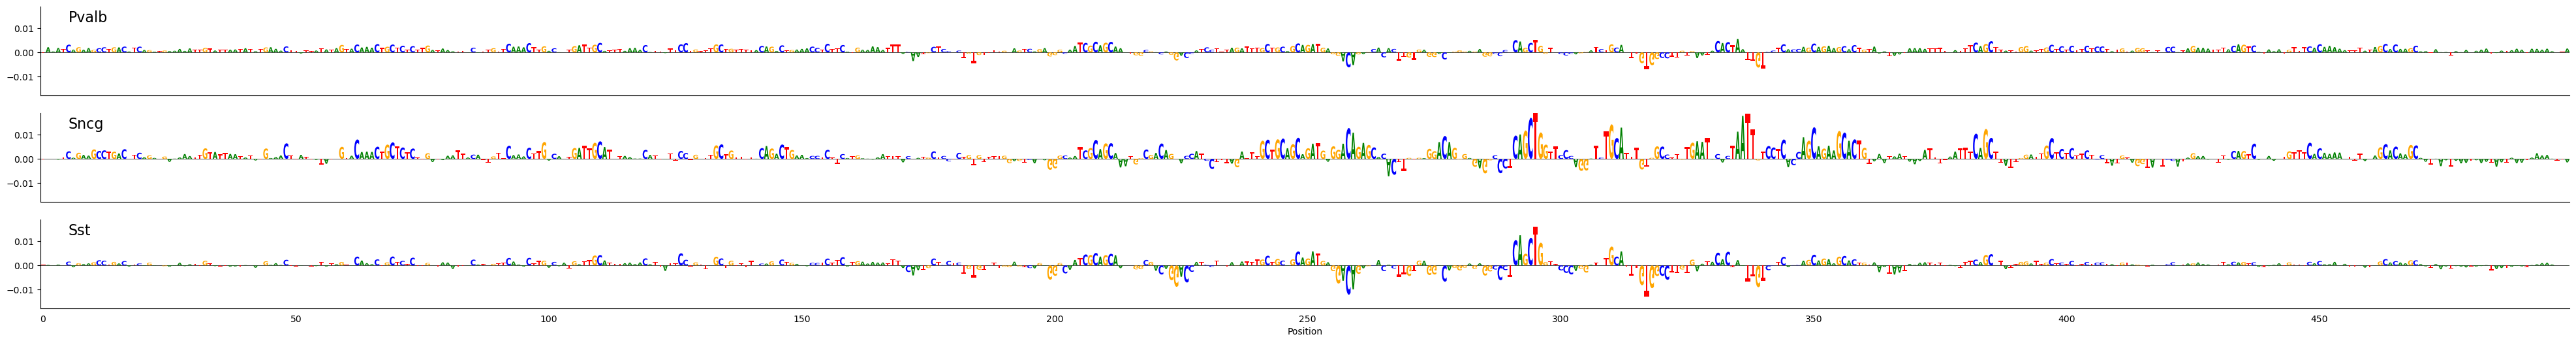

Plotting scores per seq: 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


In [250]:
idx= idx # test set index
region = bed_df.iloc[test_ids[idx]]
seq_onehot = region_to_one_hot_encoding(region['chrom'],region['start'], region['end'], genomic_pyfasta, hot_encoding_table)
#seq_onehot  = region_to_one_hot_encoding('chr18',61108377-807, 61108877+807, genomic_pyfasta, hot_encoding_table)
location = (bed_df.iloc[test_ids[idx]]['chrom'], bed_df.iloc[test_ids[idx]]['start'], bed_df.iloc[test_ids[idx]]['end'])
model='rc_TL'#'bigboy_TL_1e-5'
pred = model_dict[model].predict(seq_onehot)
max_pred_idx = np.argmax(pred[0])
subset = [max_pred_idx-1, max_pred_idx, max_pred_idx+1] # example

plot_tracks(seq_onehot, location ,model_dict[model], subset, classes)

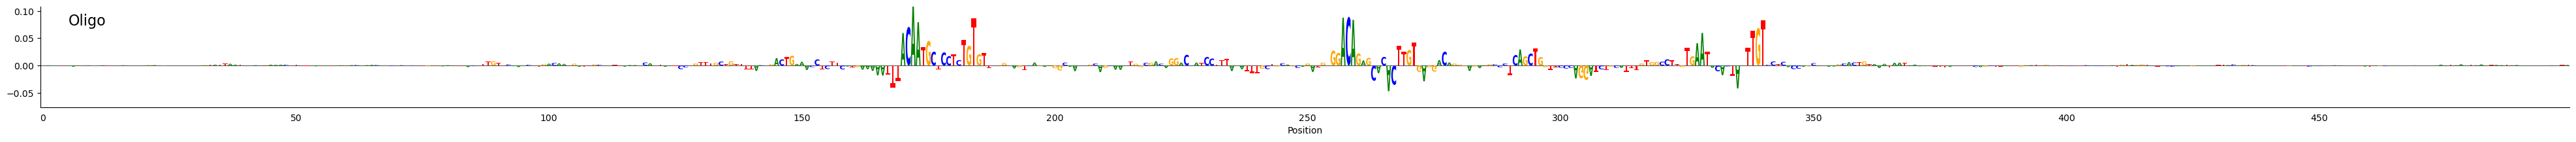

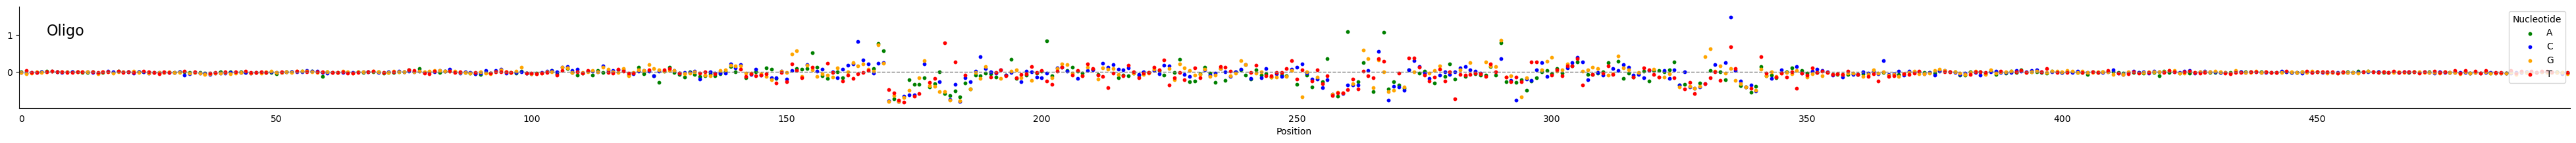

In [103]:
#idx= 4125 # test set index
region = bed_df.iloc[test_ids[idx]]
seq_onehot = region_to_one_hot_encoding(region['chrom'],region['start'], region['end'], genomic_pyfasta, hot_encoding_table)
#seq_onehot  = region_to_one_hot_encoding('chr18',61108377-807, 61108877+807, genomic_pyfasta, hot_encoding_table)
location = (bed_df.iloc[test_ids[idx]]['chrom'], bed_df.iloc[test_ids[idx]]['start'], bed_df.iloc[test_ids[idx]]['end'])
model='softplus_TL'#'bigboy_TL_1e-5'
pred = model_dict[model].predict(seq_onehot, verbose=0)
max_pred_idx = np.argmax(pred[0])
subset = [max_pred_idx-1, max_pred_idx, max_pred_idx+1] # example
subset = [max_pred_idx]
plot_tracks(seq_onehot, location ,model_dict[model], subset, classes, zoom=500)
plot_tracks(seq_onehot, location ,model_dict[model], subset, classes, zoom=500, method='mutagenesis')

1/1 [==============================] - 0s 24ms/step


Calculating scores per class for all regions: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


(1, 3, 2114, 4)


Plotting scores per seq:   0%|          | 0/1 [00:00<?, ?it/s]

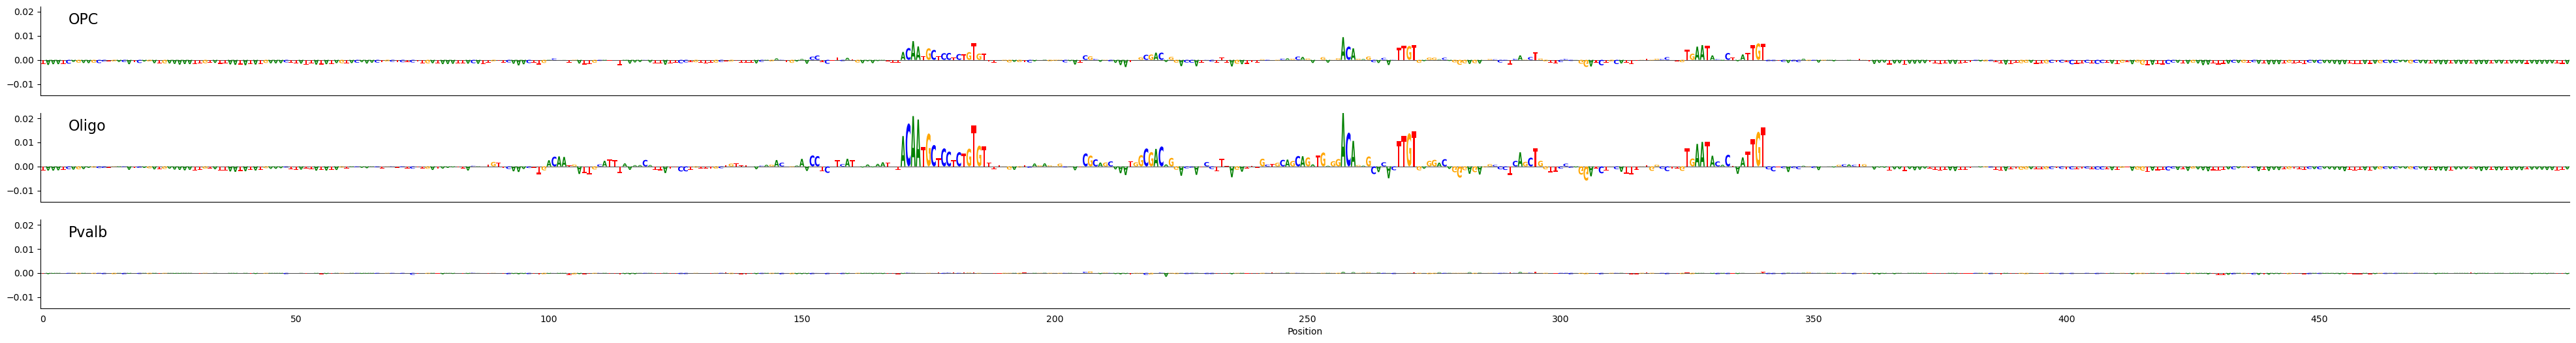

Plotting scores per seq: 100%|██████████| 1/1 [00:11<00:00, 11.11s/it]


In [252]:
#idx= 4125 # test set index
region = bed_df.iloc[test_ids[idx]]
seq_onehot = region_to_one_hot_encoding(region['chrom'],region['start'], region['end'], genomic_pyfasta, hot_encoding_table)
#seq_onehot  = region_to_one_hot_encoding('chr18',61108377-807, 61108877+807, genomic_pyfasta, hot_encoding_table)
location = (bed_df.iloc[test_ids[idx]]['chrom'], bed_df.iloc[test_ids[idx]]['start'], bed_df.iloc[test_ids[idx]]['end'])
model='bigboy_TL_1e-5'
pred = model_dict[model].predict(seq_onehot)
max_pred_idx = np.argmax(pred[0])
subset = [max_pred_idx-1, max_pred_idx, max_pred_idx+1] # example

plot_tracks(seq_onehot, location ,model_dict[model], subset, classes)

In [20]:
import shap

rn=np.random.choice(seqs.shape[0], 250, replace=False)
exp_dict = {}
exp_dict[model] = shap.DeepExplainer((model_dict[model].inputs, model_dict[model].layers[-1].output), seqs[rn])

/data/projects/c04/cbd-saerts/nkemp/software/anaconda3/envs/deeppeak/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [21]:
shap_values_, indexes_ = exp_dict[model].shap_values(seq_onehot,
                                                   output_rank_order=str(3),
                                                   ranked_outputs=1,
                                                   check_additivity=False)

In [24]:
s = np.expand_dims(shap_values_, axis=1)
s = s.squeeze(axis=4)
s.shape

(1, 1, 2114, 4)

Plotting scores per seq:   0%|          | 0/1 [00:00<?, ?it/s]

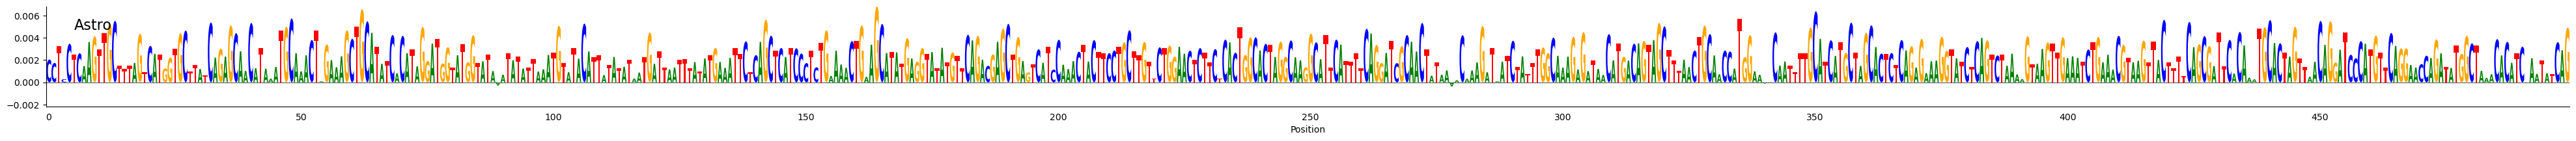

Plotting scores per seq: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


In [28]:
visualize_scores(
        s,
        seq_onehot,
        '',
        [location],
        class_indices=[0],
        zoom_n_bases=500,
        class_names=classes,
        verbose=False
    )

# Specific regions

In [167]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.metrics import jaccard_score
from tqdm import tqdm

def calc_specificity(predictions):
    specificity_scores = np.zeros_like(predictions)
    
    # Loop through each region
    for region_idx in tqdm(range(predictions.shape[0]), total=predictions.shape[0]):
        # Get the scores for the current region across all cell types
        region_scores = predictions[region_idx]
        
        # Calculate the specificity score for each cell type for the current region
        for cell_type_idx in range(predictions.shape[1]):
            # Find the index of the cell type with the highest score for the current region
            max_score_cell_type_idx = np.argmax(region_scores)
            
            # Exclude the cell type in question by setting its score to a very low value
            region_scores_without_self = region_scores.copy()
            region_scores_without_self[cell_type_idx] = -np.inf

            region_score = max(0.00001,region_scores[cell_type_idx])
            highest_among_others = max(0.00001,region_scores_without_self.max())
            
            # Calculate specificity as the difference between the score of the cell type in question
            # and the highest score among other cell types for the same region
            specificity = (region_score - highest_among_others)*(region_score/highest_among_others)
                
            # Store the specificity score in the array
            specificity_scores[region_idx, cell_type_idx] = specificity
    
    return specificity_scores

def calc_gini(predictions):
    def gini(array):
        """Calculate the Gini coefficient of a numpy array."""
        # All values are treated equally, arrays must be 1D:
        array = array.flatten()
        
        array= np.clip(array, 0, None)
        # Values cannot be 0:
        epsilon = 0.0000001
        array += epsilon
        # Values must be sorted:
        array = np.sort(array)
        # Index per array element:
        index = np.arange(1, array.shape[0] + 1)
        # Number of array elements:
        n = array.shape[0]
        # Gini coefficient:
        return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))
    gini_scores = np.zeros_like(predictions)
    # Loop through each region
    for region_idx in tqdm(range(predictions.shape[0]), total=predictions.shape[0]):
        # Get the scores for the current region across all cell types
        region_scores = predictions[region_idx]
        max_idx = np.argmax(region_scores)
        gini_scores[region_idx, max_idx] = gini(region_scores)
    return gini_scores


def sort_regions(region_scores, weight_strength=0, weight_specificity=1, only_gini=False):
    # Assuming your accessibility predictions are in a numpy array called 'predictions'
    # with shape (500000, 19).
    predictions = region_scores
    # 1. Calculate the strength score for each region and cell type
    strength_scores = predictions 

    if (not only_gini): 
        # 2. Calculate the Z-score for each region and cell type (specificity)
        specificity_scores = calc_specificity(predictions)#zscore(predictions, axis=1)  # Shape: (500000, 19)
         # 3. Combine the scores (you can adjust the weights as needed)
        combined_scores = (weight_strength * strength_scores) + (weight_specificity * specificity_scores)
        # 4. Sort the regions per cell type based on the combined scores
        sorted_regions = np.array([np.argsort(specificity_scores[:, i])[::-1] for i in range(specificity_scores.shape[1])])
    gini_scores = calc_gini(predictions)
    sorted_regions_gini = np.array([np.argsort(gini_scores[:, i])[::-1] for i in range(gini_scores.shape[1])])

    # 'sorted_regions' is a list where each element corresponds to a cell type,
    # and it contains the indices of regions sorted based on the combined score.
    if (not only_gini):
        return sorted_regions, combined_scores, sorted_regions_gini, gini_scores
    else:
        return sorted_regions_gini, gini_scores

def sim_matrix(sorted_regions, classes_x, classes_y, sorted_regions_ref=None, k=1000):

    if (sorted_regions_ref is None):
        sorted_regions_ref = sorted_regions
    
    # Initialize a similarity matrix with zeros
    num_cell_types = len(sorted_regions)
    similarity_matrix = np.zeros((len(classes_x), len(classes_y)))
    
    # Calculate Jaccard similarity between the top 'k' indices for each cell type
    for i in range(len(classes_x)):
        for j in range(len(classes_y)):
            # Extract the top 'k' indices for cell types 'i' and 'j'
            top_indices_i = set(sorted_regions[i][:k])
            top_indices_j = set(sorted_regions_ref[j][:k])
    
            # Calculate Jaccard similarity
            #jaccard_sim = len(top_indices_i.intersection(top_indices_j)) / len(top_indices_i.union(top_indices_j))
            jaccard_sim = len(top_indices_i.intersection(top_indices_j))
            
            # Store the similarity in the matrix (symmetric)
            similarity_matrix[i, j] = jaccard_sim

    
    
    # 'similarity_matrix' is the calculated similarity matrix
    # 'cell_type_names' is a list of cell type names (must be in the same order as the rows/columns of the similarity matrix)
    
    # Create a DataFrame with cell type names as row and column labels
    similarity_df = pd.DataFrame(similarity_matrix, columns=classes_y, index=classes_x)

    similarity_df = similarity_df.round(3)

    
    return similarity_df


In [168]:
#sorted_regions_data, scores_data, sorted_regions_data_gini, scores_data_gini = sort_regions(sorted_targets)
sorted_regions_data_gini, scores_data_gini = sort_regions(sorted_targets, only_gini=True)


100%|██████████| 89185/89185 [00:02<00:00, 36950.29it/s]


In [169]:
sim_df = sim_matrix(sorted_regions_data_gini, sorted_regions_ref=sorted_regions_data_gini,classes_x=classes, classes_y=classes, k=1000)
sim_df


,Astro,Endo,L2_3IT,L5ET,L5IT,L5_6NP,L6CT,L6IT,L6b,Lamp5,Micro_PVM,OPC,Oligo,Pvalb,Sncg,Sst,Sst-Chodl,VLMC,Vip
Astro,1000.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Endo,2.0,1000.0,4.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,26.0,0.0,5.0,2.0,3.0,2.0,5.0,3.0
L2_3IT,0.0,4.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L5ET,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L5IT,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L5_6NP,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L6CT,0.0,2.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L6IT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L6b,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lamp5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
def plot_predictions(location, seq_onehot, target, model_names, classes, plot_atac=True, exp=False, atac_peak=1000, padding=True):
    if(plot_atac): 
        n_plots = len(model_names)+1
    else:
        n_plots = len(model_names)
    fig = plt.figure(figsize=(35,5*n_plots))

    for i, model in enumerate(model_names):
        plt.subplot(n_plots,1,i+1)
        if(plot_atac):
            plt.bar(classes, model_dict[model].predict(seq_onehot)[0])
        else:
            plt.bar(classes, model_dict[model].predict(seq_onehot)[0])
        plt.title(model)
        plt.xlabel('Cell type')
        plt.ylabel('ATAC prediction')
        plt.grid('on')
        plt.xticks(rotation=0)
    if(plot_atac): 
        gt = target
        plt.subplot(n_plots,1,n_plots)
        plt.bar(classes, gt)
        plt.title('GT '+str(location))
        plt.xlabel('Cell type')
        plt.ylabel('Avg peak value')
        plt.grid('on')
        plt.xticks(rotation=0)

('chrX', 126303528, 126305642)
0.8815633676204214
chrX:126303528-126305642
1/1 [==============================] - 0s 25ms/step


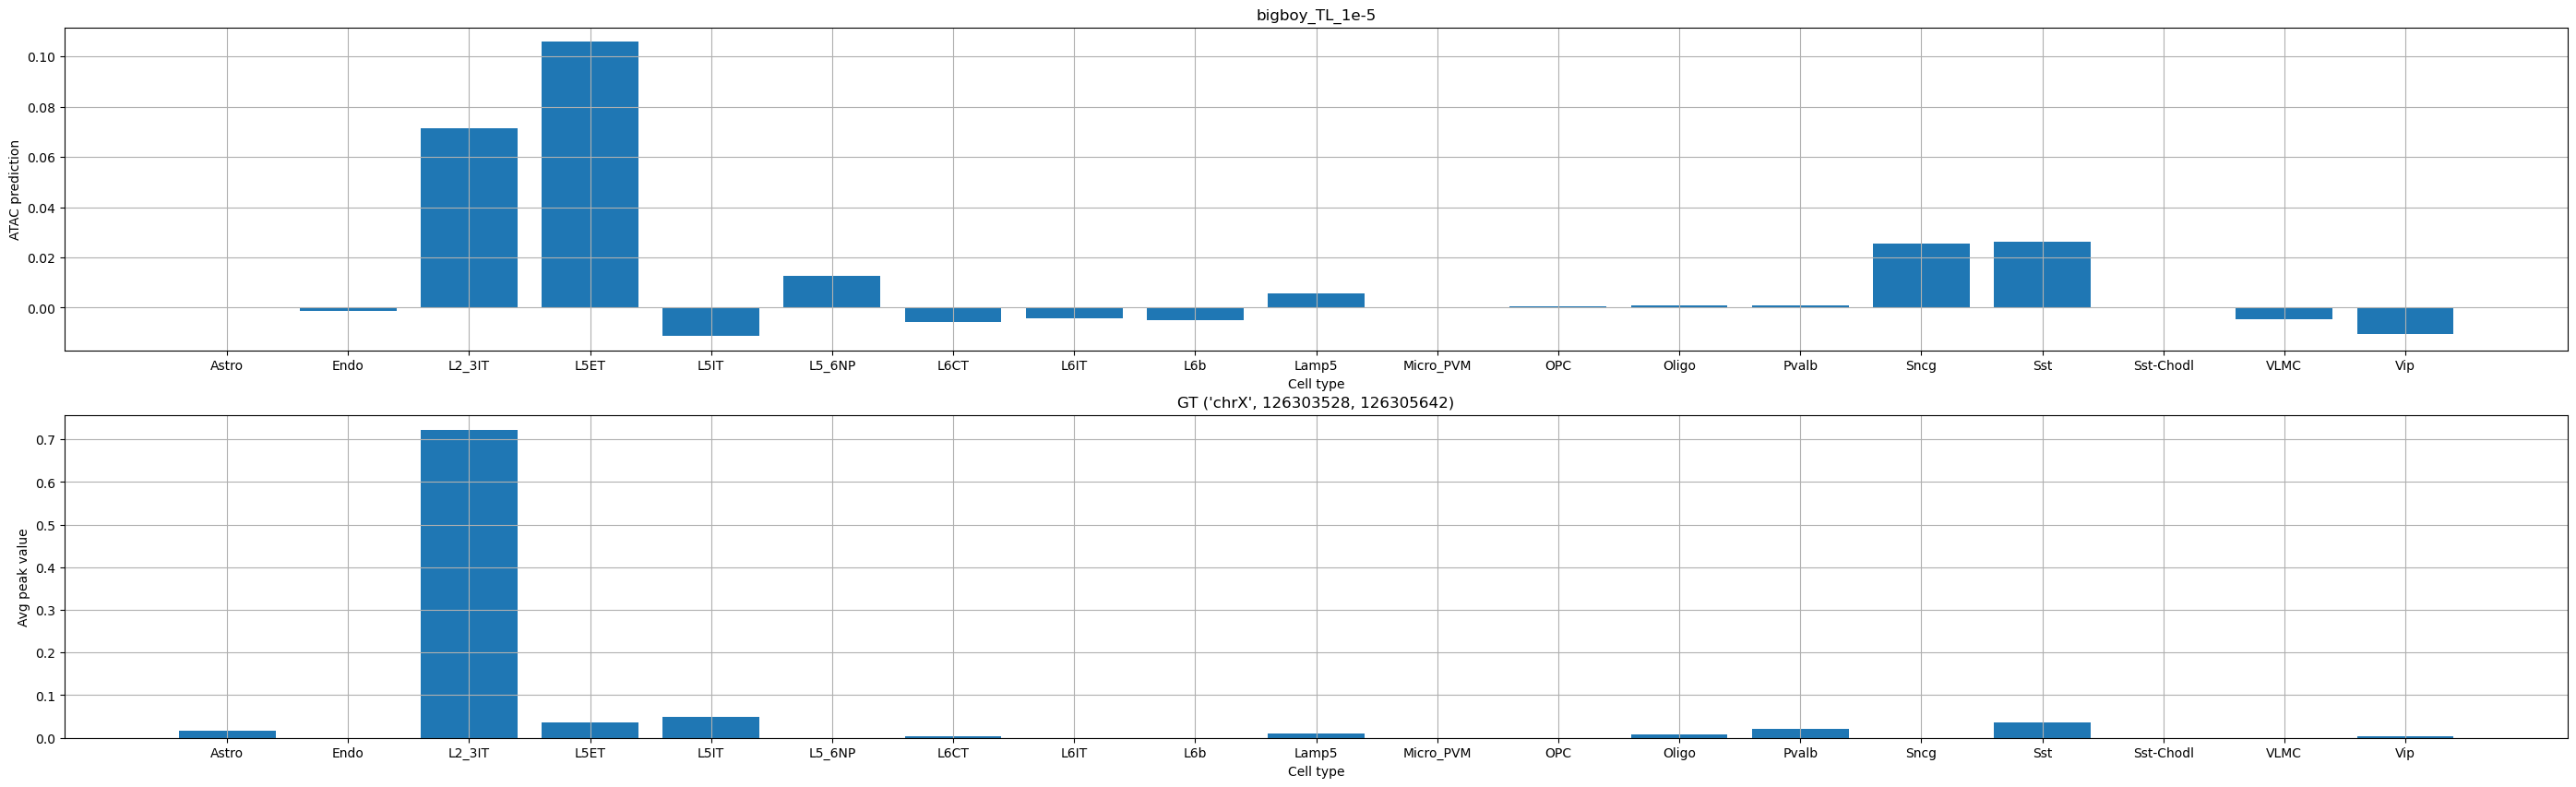

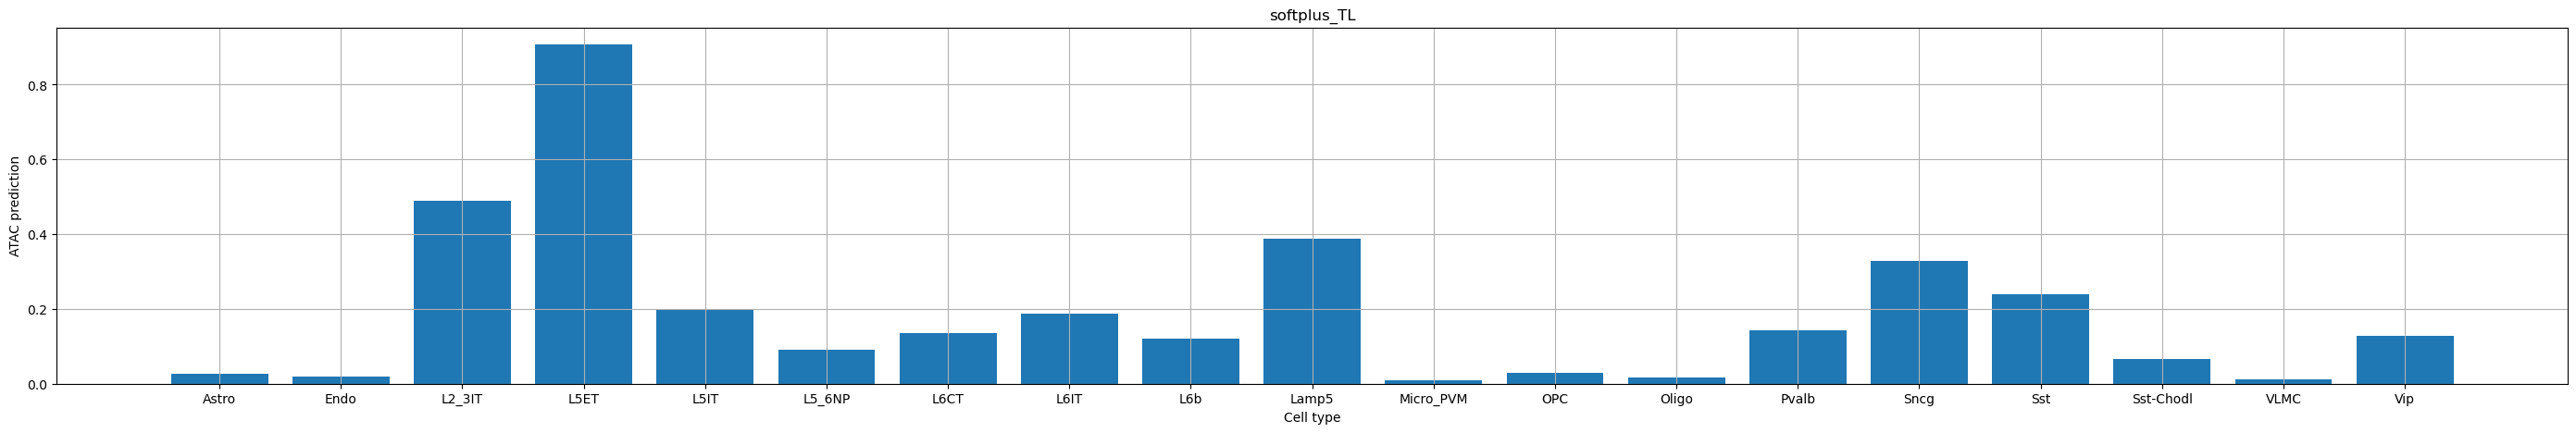

In [198]:
genomefile_path=genome
srtd_regs = sorted_regions_data_gini
srtd_scores = scores_data_gini
ct = 2
idx = 1
seq_id_row = bed_df.iloc[srtd_regs[ct,idx]]
seq_id = seq_id_row['chrom']+':'+str(seq_id_row['start'])+'-'+str(seq_id_row['end'])
location = (seq_id.split(':')[0], int(seq_id.split(':')[1].split('-')[0]), int(seq_id.split(':')[1].split('-')[1]))
print(location)
print(srtd_scores[srtd_regs[ct,idx], ct])
print(seq_id)


seq_onehot = region_to_one_hot_encoding(seq_id_row['chrom'],seq_id_row['start'], seq_id_row['end'], genomic_pyfasta, hot_encoding_table)
#seq_onehot = utils.one_hot_encode_along_row_axis(BedTool.seq(location, genomefile_path))
#plot_predictions(location,seq_onehot, sorted_targets[srtd_regs[ct,idx]],['bigboy'], classes_, plot_atac=False)
plot_predictions(location,seq_onehot, sorted_targets[srtd_regs[ct,idx]],['bigboy_TL_1e-5'], classes)

plot_predictions(location,seq_onehot, sorted_targets[srtd_regs[ct,idx]],['softplus_TL'], classes, plot_atac=False)


Plotting scores per seq:   0%|          | 0/1 [00:00<?, ?it/s]

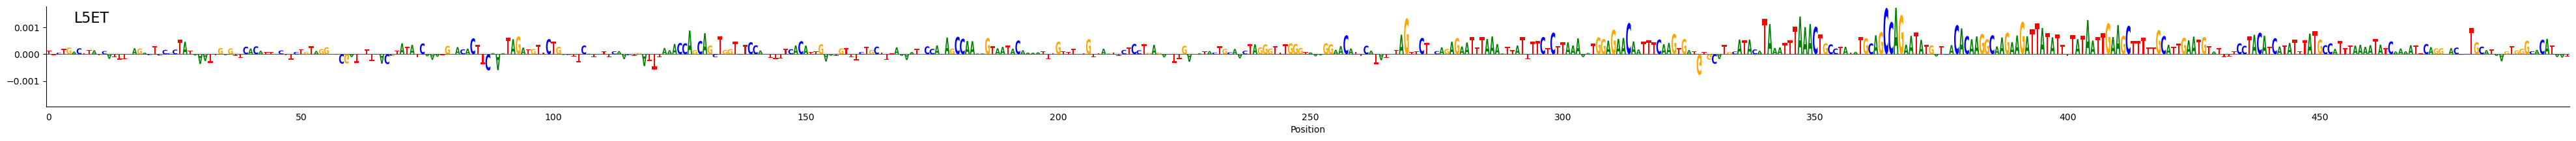

Plotting scores per seq: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [169]:
subset = np.arange(3,4)
plot_tracks(seq_onehot, location, model_dict['bigboy_TL_1e-5'], subset, classes, method='integrated_grad')

### Write to bed and fasta files

In [48]:
top_k = 500

outBedDir = '/data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed/'
mapping_file = '/data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/mapping.txt'
os.makedirs(outBedDir, exist_ok=True)

# loop over cell types and write BED files
for a, celltype in enumerate(classes_):
    ct_filtered = celltype.replace("/", "_").replace(" ", "_")
    with open(mapping_file, 'a') as mfile:
        mfile.write(ct_filtered +'\t'+str(a)+'\n')
    outf = outBedDir + '/' + ct_filtered + '.bed' 
    with open(outf, 'w') as file:
        for i in range(0, top_k):
            seq_id_row = bed_df.iloc[srtd_regs[a,i]]
            seq_id = seq_id_row['chrom']+':'+str(seq_id_row['start'])+'-'+str(seq_id_row['end'])
            s1 = seq_id.split(":")
            s2 = s1[1].split("-")
            name = seq_id
            outstr = s1[0] + '\t' + str(s2[0]) + '\t' + str(s2[1]) + '\t' + name + '\t.\t.\n'  
            file.write(outstr)
            
    print("Output written to: " + outf)

Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//001_CLA-EPd-CTX_Car3_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//002_IT_EP-CLA_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//003_L5_6_IT_TPE-ENT_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//004_L6_IT_CTX_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//005_L5_IT_CTX_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//006_L4_5_IT_CTX_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//007_L2_3_IT_CTX_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//008_L2_3_IT_ENT_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/bed//009_L2_3_IT_PIR-ENTl_Glut.bed
Output written to: /data/projects/c04/cbd-saerts/nkemp/mouse/wmb/

# TF-MoDISco

In [3]:
from vizsequence.viz_sequence import *
default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
dna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
rna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_u}
def plot_weights_given_ax(ax, array,       
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency="auto",
                 colors=default_colors,
                 plot_funcs=dna_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    if (subticks_frequency=="auto"):
        subticks_frequency = 1.0 if len(array) <= 40 else int(len(array)/40)
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far,
                      left_edge=i+0.5, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(0.5-length_padding, 0.5+array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(1.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    #ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)
    return ax

[16, 17]
7
['neg_patterns', 'pos_patterns']
1
neg_patterns pattern_0
total seqlets: 45
2
neg_patterns pattern_1
total seqlets: 22
['neg_patterns', 'pos_patterns']
1
neg_patterns pattern_0
total seqlets: 51
2
neg_patterns pattern_1
total seqlets: 33
3
neg_patterns pattern_2
total seqlets: 29
4
neg_patterns pattern_3
total seqlets: 29
5
neg_patterns pattern_4
total seqlets: 21
6
neg_patterns pattern_5
total seqlets: 20
7
neg_patterns pattern_6
total seqlets: 20


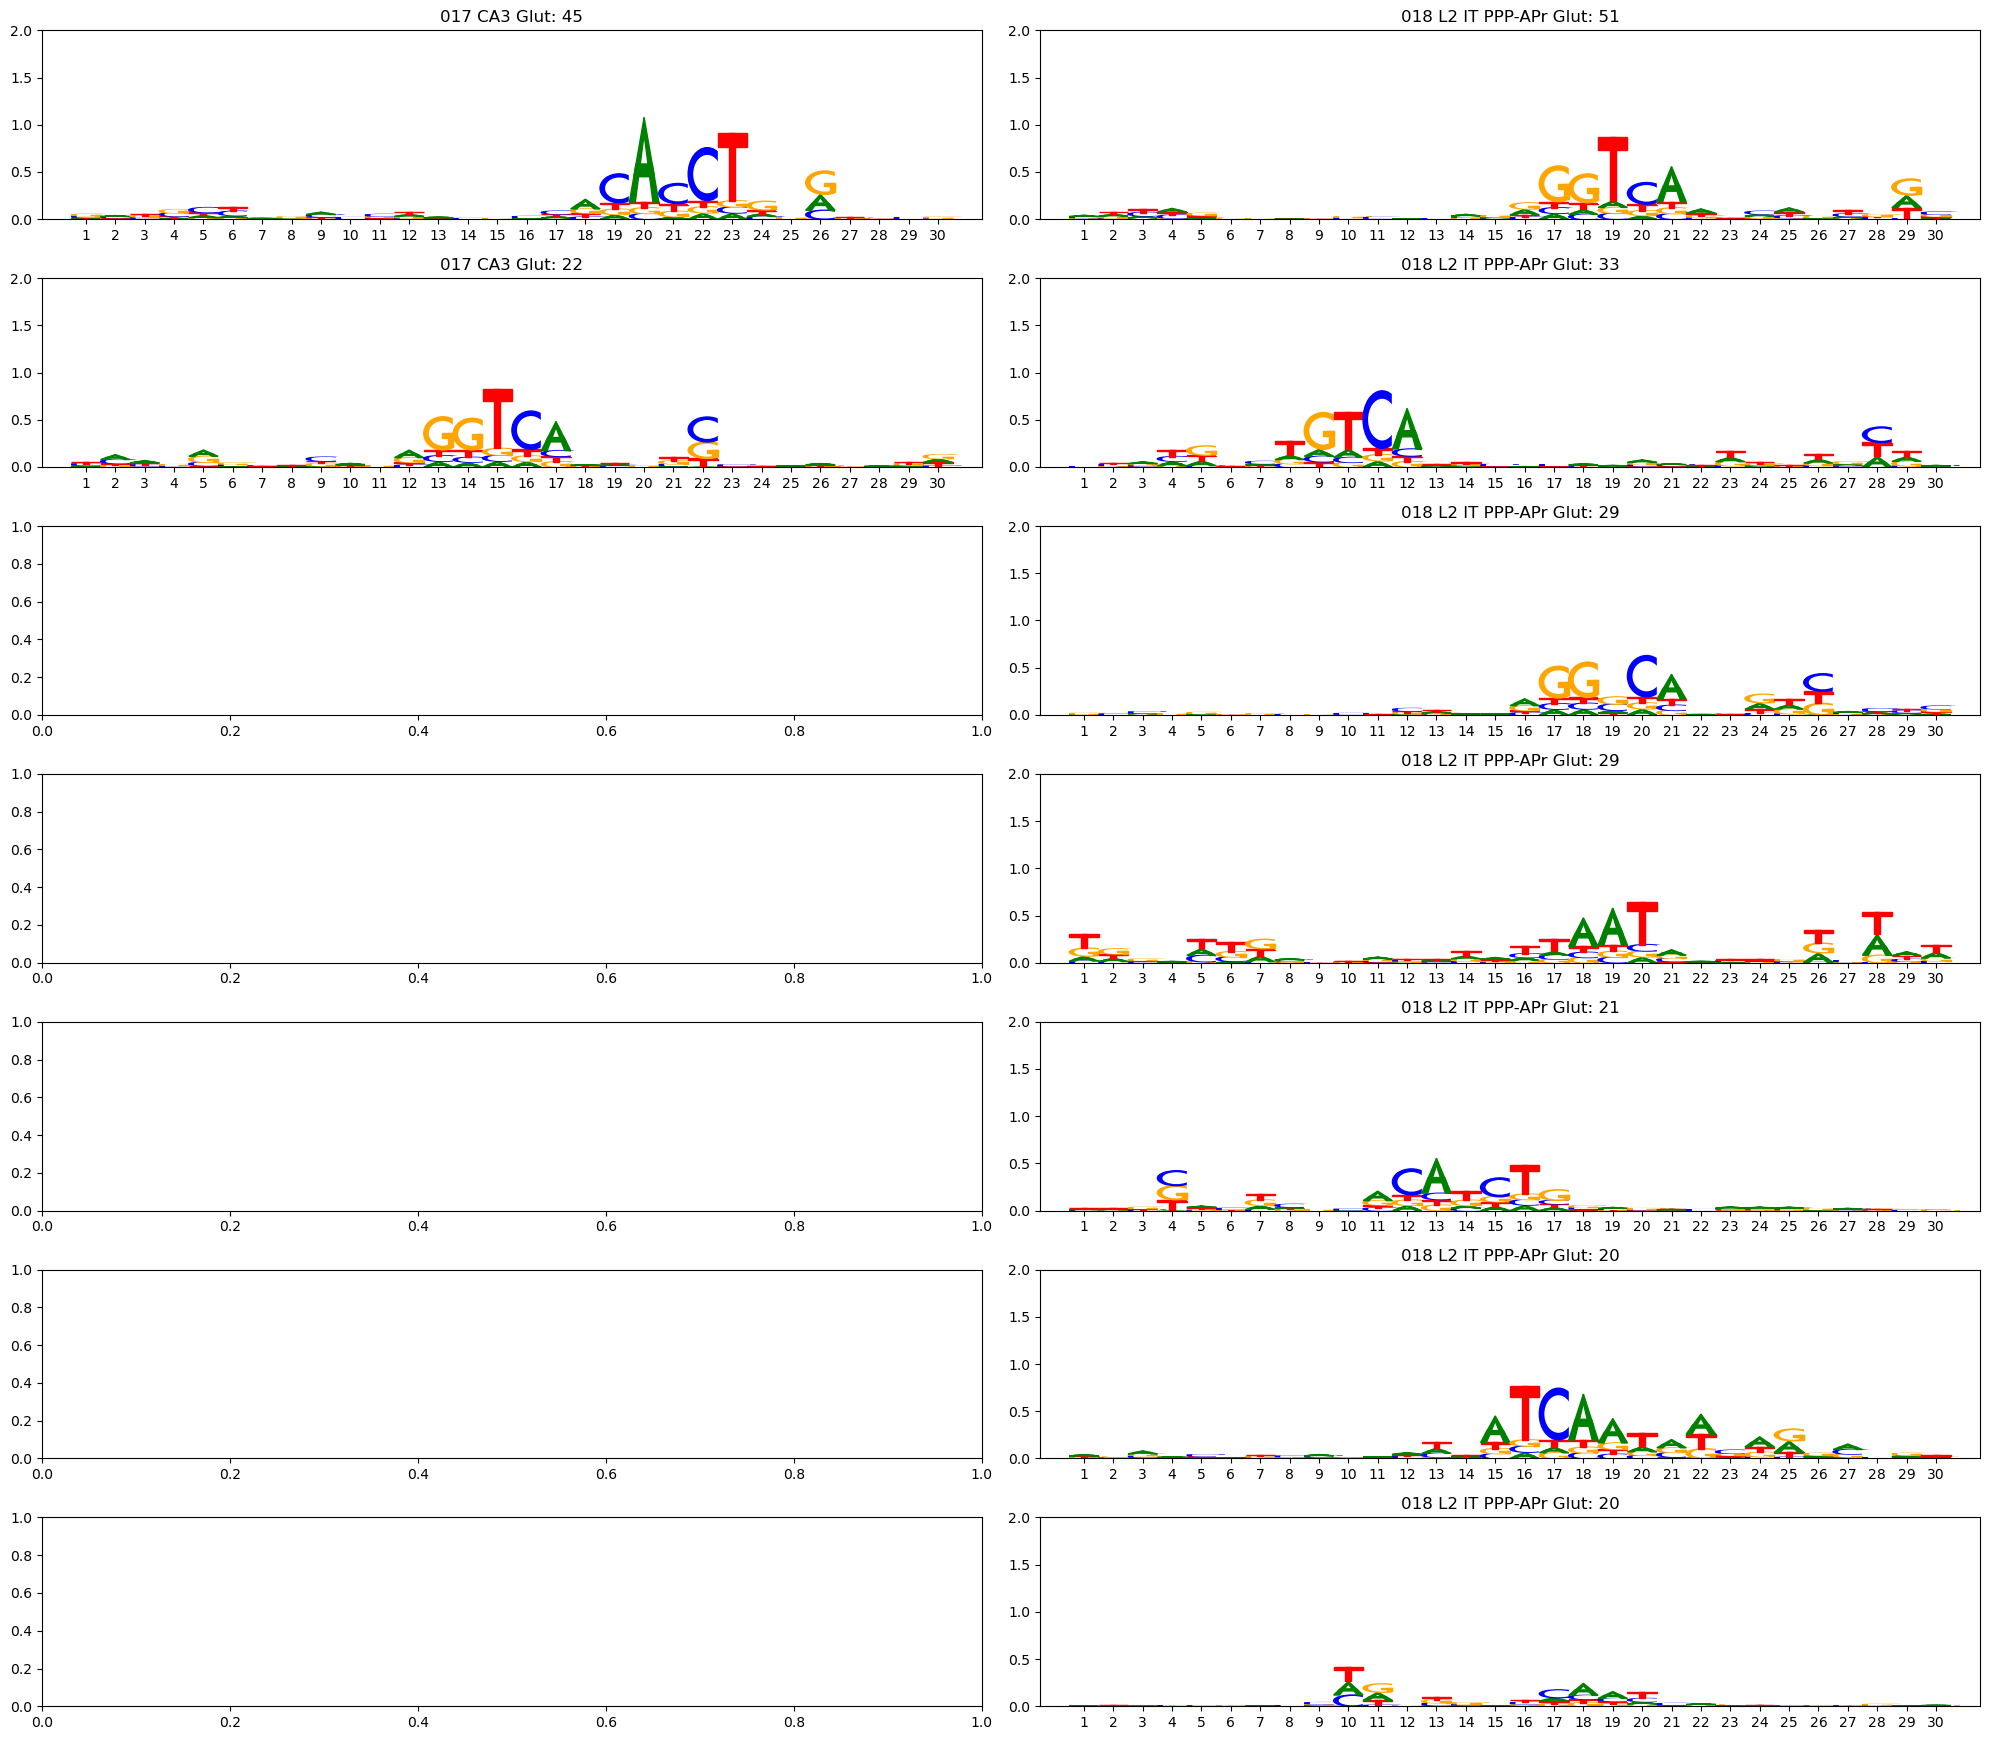

In [15]:
from matplotlib import pyplot as plt
import h5py
import pickle
import numpy as np
import vizsequence

# Initialize
all_patterns = []
total_patterns = 0
max_num_patterns = 0
motif_counter = 1
topics = range(20,27)  # Assuming topics are numbered from 1 to 7
topics = [1,2,11,12,13,18]
topics = [10,14,16,17,19]
topics = [0,1,2,3,4,5,6,7,8,9]
topics = np.arange(0,15)
substring='CA'
topics = [i for i, string in enumerate(classes_) if substring in string]
topics = [16,17]
print(topics)

outdir = '/data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/contribution_scores/'
# Find max_num_patterns across all topics
for topic in topics:
    cell_type = classes_[topic].replace("/", "_").replace(" ", "_")
    hdf5_results = h5py.File(f"{outdir}/{cell_type}_modisco_results.h5", "r")
    metacluster_names = list(hdf5_results.keys())

    for metacluster_name in ['neg_patterns']:#metacluster_names:
        all_pattern_names = list(hdf5_results[metacluster_name])
        max_num_patterns = max(max_num_patterns, len(all_pattern_names))

# Create a single figure based on the total number of patterns
figure, axes = plt.subplots(nrows=max_num_patterns, ncols=len(topics), figsize=(10 * len(topics), 2.5 * max_num_patterns))

# Flatten axes array for easy access if it's multidimensional
axes_flat = axes.flatten()
print(max_num_patterns)

background = np.array([0.27, 0.23, 0.23, 0.27])
# Nested loops to go through topics, metaclusters, patterns, and tasks
for topic_idx, topic in enumerate(topics):
    cell_type = classes_[topic].replace("/", "_").replace(" ", "_")
    hdf5_results = h5py.File(f"{outdir}/{cell_type}_modisco_results.h5", "r")
    metacluster_names = list(hdf5_results.keys())

    print(metacluster_names)
    for metacluster_name in ['neg_patterns']:#metacluster_names:
        all_pattern_names = list(hdf5_results[metacluster_name])

        for pattern_idx, pattern_name in enumerate(all_pattern_names):
            print(motif_counter)
            ax = axes[motif_counter-1, topic_idx]#axes_flat[motif_counter-1]
            motif_counter += 1
            print(metacluster_name, pattern_name)
            all_patterns.append((metacluster_name, pattern_name))
            pattern = hdf5_results[metacluster_name][pattern_name]
            num_seqlets = list(hdf5_results[metacluster_name][pattern_name]['seqlets']['n_seqlets'])[0]
            print("total seqlets:",num_seqlets)
            if (num_seqlets<0):
                break
            t=classes_[topic]
            subplot_idx = (pattern_idx * len(topics)) + topic_idx + 1
            counts = np.array(hdf5_results[metacluster_name][pattern_name]['contrib_scores'])
            counts = -counts
            #counts[counts<0]=0
            min_val = np.min(counts)
            counts = counts+np.abs(min_val)
            ppm = counts/np.sum(counts, axis=1)[:, None]
            ax = plot_weights_given_ax(ax,ic_scale(ppm, background))
            #ax = plot_weights_given_ax(ax,np.array(hdf5_results[metacluster_name][pattern_name]['contrib_scores']))
            ax.set_ylim([-0.01, 0.09])
            ax.set_ylim([0,2])
            ax.set_title(classes_[topic]+': '+str(num_seqlets))
            #ax.set_ylim([-0.01, 0.005])
    motif_counter=1
#plt.savefig('inh_top500.png')
plt.tight_layout()
filename = ''
for topic in topics:
    filename += str(topic)+'_'
plt.savefig('/data/projects/c04/cbd-saerts/nkemp/mouse/wmb/top_500/'+filename+'.pdf')
plt.show()

In [61]:
list(hdf5_results[metacluster_name][pattern_name])

['contrib_scores',
 'hypothetical_contribs',
 'seqlets',
 'sequence',
 'subpattern_0']

In [82]:
def get_logodds_pwm(ppm, background, pseudocount):
    assert len(ppm.shape)==2
    assert ppm.shape[1]==len(background),\
            "Make sure the letter axis is the second axis"
    assert (np.max(np.abs(np.sum(ppm, axis=1)-1.0)) < 1e-7),(
             "Probabilities don't sum to 1 along axis 1 in "
             +str(ppm)+"\n"+str(np.sum(ppm, axis=1)))
    alphabet_len = len(background)
    odds_ratio = ((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/(
                  background[None,:])
    return np.log(odds_ratio)

In [106]:
get_logodds_pwm(ppm, background=background, pseudocount=1)

array([[ 0.28184715, -0.08058083, -0.10142847, -0.19535976],
       [-0.11710552,  0.15899734, -0.07190506,  0.02255086],
       [-0.05673543,  0.07794865,  0.05118888, -0.06043165],
       [ 0.04058983,  0.01871274,  0.0976019 , -0.15647895],
       [-0.10900539,  0.10626456,  0.09634553, -0.08163065],
       [ 0.3062499 , -0.08140806, -0.03885327, -0.30010459],
       [-0.25709689, -0.13177733, -0.13976194,  0.36671786],
       [-0.30010459, -0.13159246,  0.53677517, -0.27566292],
       [ 0.35884679, -0.13976194, -0.08192598, -0.29243976],
       [-0.24573594,  0.47156141, -0.09967269, -0.24150177],
       [-0.13381232, -0.13976194, -0.11238053,  0.28284934],
       [-0.2475938 ,  0.52605827, -0.13976194, -0.30010459],
       [ 0.37828376, -0.11124807, -0.13976194, -0.29972805],
       [-0.28678148,  0.2958604 , -0.12386853,  0.05381632],
       [-0.03463634,  0.13497162,  0.16202508, -0.27297067],
       [-0.11831571,  0.1530119 , -0.02120462, -0.01145201],
       [-0.03177464,  0.

In [115]:
counts = np.array(hdf5_results[metacluster_name][pattern_name]['contrib_scores'])
#min_val = np.min(counts)
counts[counts<0]=0
ppm = counts/np.sum(counts, axis=1)[:, None]

In [116]:
ppm


array([[0.28536985, 0.32079204, 0.27553381, 0.1183043 ],
       [0.39631602, 0.33331534, 0.01496589, 0.25540276],
       [0.2354512 , 0.40025322, 0.10186661, 0.26242897],
       [0.36480379, 0.28968355, 0.2765256 , 0.06898706],
       [0.39774487, 0.40951826, 0.        , 0.19273687],
       [0.32369188, 0.19662473, 0.07702135, 0.40266204],
       [0.25310575, 0.        , 0.30290337, 0.44399088],
       [0.        , 0.72987224, 0.14676167, 0.12336609],
       [0.44419415, 0.52397776, 0.        , 0.03182809],
       [0.36634695, 0.21395099, 0.06544981, 0.35425225],
       [0.10753964, 0.37495186, 0.26931865, 0.24818985],
       [0.09002426, 0.35208487, 0.35477384, 0.20311703],
       [0.10239951, 0.47646417, 0.01473475, 0.40640158],
       [0.18024072, 0.08009092, 0.08011221, 0.65955615],
       [0.34375436, 0.32472303, 0.10855302, 0.22296959],
       [0.41224974, 0.06789614, 0.22111998, 0.29873414],
       [0.        , 0.97569222, 0.02430778, 0.        ],
       [0.60722862, 0.01839767,

In [101]:
np.max(np.abs(np.sum(ppm, axis=1)-1.0))

2.220446049250313e-16